In [1]:
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.core.display as di

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.optimizers import  Adam


Using TensorFlow backend.


In [2]:
%matplotlib inline
color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [3]:
# import dataset
df = pd.read_csv("20110810_preprocessing.txt")
df = df.sort_values(by="StartTime").reset_index(drop=False)
df["index"] = df.index
df.head()

,index,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,label
0,0,35213.0473,3550.1824,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0000,0.0000,12,875,413,0
1,1,35213.0488,0.0009,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0000,0.0000,2,135,75,0
2,2,35213.0499,0.0003,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0000,0.0000,2,120,60,0
3,3,35213.0538,0.0570,tcp,83.3.77.74,32882,<?>,147.32.85.5,21857,FA_FA,0.0000,0.0000,3,180,120,0
4,4,35213.0539,3427.7681,udp,74.89.223.204,21278,<->,147.32.84.229,13363,CON,0.0000,0.0000,42,2856,1596,0


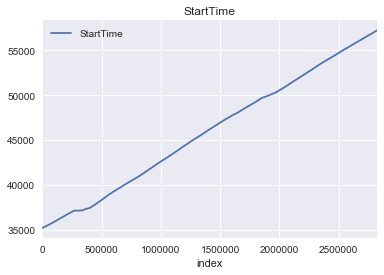

In [4]:
# plot start time 
df.plot(x='index', y='StartTime', title="StartTime")
plt.show()

### 將IP轉換成一個time window內的排名

size of1time_window : 299


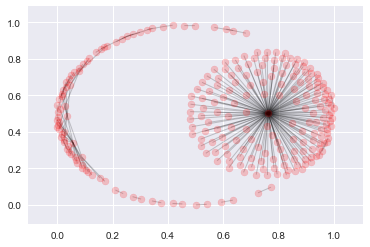

number of IP in one time_window: 248


,SrcAddr,num,DstAddr,rank
0,212.50.71.179,1,212.50.71.179,134.0000
1,147.32.84.229,161,147.32.84.229,1.0000
2,84.13.246.132,1,84.13.246.132,134.0000
3,217.163.21.35,1,217.163.21.35,134.0000
4,147.32.86.194,4,147.32.86.194,5.5000


In [5]:
# example for network plot 
tw = 1

i = 0
df1 = df[(df.StartTime > int(np.min(df.StartTime))+i)&(df.StartTime <= int(np.min(df.StartTime))+i+tw)]
print('size of'+str(i+1)+'time_window :', df1.shape[0])

G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
nx.shortest_path(G)
nx.draw_networkx(G, node_size = 50, alpha = 0.2, with_labels = False)
plt.show()

# Count degree and rank
deg = pd.DataFrame(G.degree_iter())
deg.columns = ["SrcAddr", "num"]
deg["DstAddr"] = deg.SrcAddr
deg["rank"] = deg.num.rank(axis=0, method = 'average', numeric_only = None, na_option = 'keep', ascending = False, pct = False)
print('number of IP in one time_window:', deg.shape[0])
deg.head()


In [6]:
def IP2deg(df, deg):
    df1 = df.merge(deg.iloc[:,[0,3]], how = 'inner', on = "SrcAddr")
    df2 = df1.merge(deg.iloc[:,[2,3]], how = 'inner', on = "DstAddr")
    df2.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
    df2 = df2.sort_values(by=["StartTime"], ascending = True).reset_index(drop = True)
    return df2

In [7]:
df_deg = IP2deg(df1[["StartTime", "SrcAddr", "DstAddr", "label"]], deg)
df_deg

,StartTime,SrcAddr1,DstAddr1,label,SrcAddr,DstAddr
0,35213.0473,212.50.71.179,147.32.84.229,0,134.0000,1.0000
1,35213.0488,84.13.246.132,147.32.84.229,0,134.0000,1.0000
2,35213.0499,217.163.21.35,147.32.86.194,0,134.0000,5.5000
3,35213.0538,83.3.77.74,147.32.85.5,0,134.0000,9.0000
4,35213.0539,74.89.223.204,147.32.84.229,0,134.0000,1.0000
5,35213.0569,66.169.184.207,147.32.84.229,0,134.0000,1.0000
6,35213.0587,182.239.167.121,147.32.84.229,0,134.0000,1.0000
7,35213.0588,147.32.3.93,147.32.84.59,0,134.0000,2.0000
8,35213.0621,24.117.206.20,147.32.84.229,0,134.0000,1.0000
9,35213.0684,94.208.78.74,147.32.84.229,0,134.0000,1.0000


### for loop

In [8]:
# 一秒為一個timewindow
tw = 1
dur = (int(np.max(df.StartTime)+1) - int(np.min(df.StartTime))) / tw
type(dur), dur

(float, 22035.0)

In [9]:
# 一秒為一個timewindow
tw = 1
dur = int((int(np.max(df.StartTime)+1) - int(np.min(df.StartTime))) / tw)

try:
    appended_data = pd.read_csv('starttime_rnn.csv')
except:
    y = []
    for i in range(dur):
        df1 = df[(df.StartTime > int(np.min(df.StartTime))+i)&(df.StartTime <= int(np.min(df.StartTime))+i+tw)]
        if df1.shape[0] == 0:
            pass
        else:
            print( str(i+1)+" /"+str(dur), df1.shape[0])
            # Count degree and rank
            G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
            deg = pd.DataFrame(G.degree_iter(), columns=["SrcAddr", "num"])
            deg["DstAddr"] = deg.SrcAddr
            deg["rank"] = deg.num.rank(axis=0, method = 'average', numeric_only = None, na_option = 'keep', ascending = False, pct = False)
            print('number of IP in one time_window:', deg.shape[0])
            df_deg = IP2deg(df1[["StartTime", "SrcAddr", "DstAddr", "label"]], deg)
            df_deg["tw"] = (i+1)
            y.append(df_deg)

    appended_data = pd.concat(y, axis = 0).reset_index(drop = True)
    appended_data.to_csv("starttime_rnn.csv", index=False)
print(appended_data.shape)
appended_data.head()

(2824636, 7)


,StartTime,SrcAddr1,DstAddr1,label,SrcAddr,DstAddr,tw
0,35213.0473,212.50.71.179,147.32.84.229,0,134.0000,1.0000,1
1,35213.0488,84.13.246.132,147.32.84.229,0,134.0000,1.0000,1
2,35213.0499,217.163.21.35,147.32.86.194,0,134.0000,5.5000,1
3,35213.0538,83.3.77.74,147.32.85.5,0,134.0000,9.0000,1
4,35213.0539,74.89.223.204,147.32.84.229,0,134.0000,1.0000,1


In [10]:
# MinMaxScaler to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1), copy = True)

X = appended_data.iloc[:, 4:6]
X = pd.DataFrame(sc.fit_transform(X), columns=["SrcAddr","DstAddr"])
df = pd.concat([X, appended_data.label], axis=1)

# Training and Testing
test = df[(df.index % 10 == 1)].reset_index(drop=True)
train = df[(df.index % 10 != 1)].reset_index(drop=True)

print ('size of train :', train.shape[0])
print ('size of tset  :', test.shape[0])

size of train : 2542172
size of tset  : 282464


In [11]:
X.describe()

,SrcAddr,DstAddr
count,2824636.0000,2824636.0000
mean,0.0647,0.0305
std,0.0440,0.0712
min,0.0000,0.0000
25%,0.0079,0.0000
50%,0.0816,0.0029
75%,0.0954,0.0728
max,1.0000,1.0000


In [12]:
def reshape(df):
    seq_length = 1
    x = np.array(df[["SrcAddr", "DstAddr"]])
    X = np.reshape(x, (len(x), seq_length, 2))
    X = X / np.max(df.SrcAddr)
    
    y = np.array(df[["label"]])
    Y = np_utils.to_categorical(y)
    print ("shape of input&output of rnn :", X.shape[0])
    print ("size of botnet               :", np.sum(y))
    return X, Y

In [13]:
X_, y_ = reshape(df)
X_train, y_train = reshape(train)
X_test, y_test = reshape(test)

cw0 = appended_data["label"].value_counts()[0]/appended_data.shape[0]
cw1 = appended_data["label"].value_counts()[1]/appended_data.shape[0]
print ("=============================================================")
print ("class_weight_0 :", cw0, "class_weight_1 :", cw1)
print ("Baseline :", sum(y_test[:,0])/X_test.shape[0])


shape of input&output of rnn : 2824636
size of botnet               : 40961
shape of input&output of rnn : 2542172
size of botnet               : 36843
shape of input&output of rnn : 282464
size of botnet               : 4118
class_weight_0 : 0.985498662483 class_weight_1 : 0.0145013375175
Baseline : 0.985421151014


### Building rnn model

In [14]:
model = Sequential()
model.add(LSTM(256, return_sequences = True, dropout=0.4,
               input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences = False, dropout=0.4))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            265216    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total para

In [ ]:
nb_epoch = 10
batch_size = 1

history = model.fit(X_train, y_train,
                    epochs = nb_epoch,  
                    batch_size = batch_size,  
                    verbose = 2,
                    shuffle = False,
                    validation_split = 0.1,  
                    class_weight = {0: cw0, 1: cw1})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
plt.figure(figsize=(20, 12))
plt.subplot(211)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(212)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()


In [ ]:
score = model.evaluate(X_test, y_test, verbose = 2)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Evaluation
def evaluation(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_ = auc(fpr, tpr)
    cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

    np.set_printoptions(precision=2)
    class_names = ["normal", "botnet"]

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names,
                          title = 'Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes = class_names, normalize = True,
                          title = 'Normalized confusion matrix')
    print("------------------------------------")
    print("Baseline    : %.6f" % (1 - sum(y_true)/y_true.shape[0]))
    print("Precision   : %f" % precision_score(y_true, y_pred))
    print("Recall      : %f" % recall_score(y_true, y_pred))
    print("F1-Score    : %f" % f1_score(y_true, y_pred))
    print("AUC         : %f" % auc_)
    plt.show()


In [ ]:
y_true = y_test[:,1]
y_pred = model.predict_classes(X_test, verbose=2)
evaluation(y_true, y_pred)


## Testing

In [ ]:
df_11 = pd.read_csv("20110811_preprocessing.txt")


In [ ]:
tw = 1
dur = (int(np.max(df_11.StartTime)+1) - int(np.min(df_11.StartTime)))
print ("number of time_window :", dur)

try:
    appended_data_11 = pd.read_csv('starttime_rnn_11.csv')
except:
    y = []
    for i in range(dur):
        df1 = df_11[(df_11.StartTime > int(np.min(df_11.StartTime))+i)&(df_11.StartTime <= int(np.min(df_11.StartTime))+i+tw)]
        if df1.shape[0] == 0:
            pass
        else:
            print( str(i+1)+" /"+str(dur), df1.shape[0])
            # Count degree and rank
            G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
            deg = pd.DataFrame(G.degree_iter(), columns=["SrcAddr", "num"])
            deg["DstAddr"] = deg.SrcAddr
            deg["rank"] = deg.num.rank(axis=0, method = 'average', numeric_only = None, na_option = 'keep', ascending = False, pct = False)
            print('number of IP in one time_window:', deg.shape[0])
            df_deg = IP2deg(df1[["StartTime", "SrcAddr", "DstAddr", "label"]], deg)
            df_deg["tw"] = (i+1)
            y.append(df_deg)

    appended_data_11 = pd.concat(y, axis = 0).reset_index(drop = True)
    appended_data_11.to_csv("starttime_rnn_11.csv", index=False)
print(appended_data_11.shape)
appended_data_11.head()

In [ ]:
# MinMaxScaler to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1), copy = True)
Z = pd.DataFrame(sc.fit_transform(appended_data_11.iloc[:, 3:6]), columns = appended_data_11.iloc[:, 3:6].columns)

# reshape to rnn input&output
test_X, test_y = reshape(appended_data_11)
print ("baseline :", appended_data_11["label"].value_counts()[0]/appended_data_11.shape[0])


In [ ]:
y_true = test_y[:,1]
y_pred = model.predict_classes(test_X, verbose = 2)
evaluation(y_true, y_pred)
